## Given edit and corresponding logit bump, examine the differences 
(run from root)

In [2]:
# General imports
import torch
import numpy as np
import os, sys
import json

from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn import metrics
from scipy import stats
import pandas as pd
from collections import Counter
from datetime import datetime
import math

In [3]:
# Local imports
sys.path.insert(0, 'src')
from utils import read_json, read_lists, list_to_dict, ensure_dir, load_image
from utils.df_utils import load_and_preprocess_csv
from utils.visualizations import plot, make_grid, show_image_rows, histogram, boxplot
from utils.analysis_utils import get_IOU, get_spearman

In [4]:
# Define constants, paths
class_list_path = os.path.join('metadata', 'cinic-10', 'class_names.txt')
class_list = read_lists(class_list_path)
class_idx_dict = list_to_dict(class_list)

n_select = 100

edit_trial_dir_template = 'saved/edit_eac/trials/CINIC10_ImageNet-VGG_16/{}_{}/0214_112633'
logit_bump_dir_template = 'saved/edit_eac/experiments/corresponding_bump_edits/CINIC10_ImageNet-VGG_16/0227_144100/{}_{}' 


In [5]:
# Load pre edit logits
pre_edit_logits_path = 'metadata/CINIC10_ImageNet-VGG_16/pre_edit_validation_set/pre_edit_logits.pth'
pre_edit_logits = torch.load(pre_edit_logits_path)
pre_edit_predictions = torch.argmax(pre_edit_logits, dim=1)
print("Loaded pre-edit logits from {}".format(pre_edit_logits_path))

# Load labels
val_labels_path = 'paths/datasets/cinic-10-imagenet/valid_labels.txt'
val_labels = np.array(read_lists(val_labels_path))
val_labels = val_labels.astype(float)
print("Loaded ground truth labels for validation set from {}".format(val_labels_path))



Loaded pre-edit logits from metadata/CINIC10_ImageNet-VGG_16/pre_edit_validation_set/pre_edit_logits.pth
Loaded ground truth labels for validation set from paths/datasets/cinic-10-imagenet/valid_labels.txt


### Calculate IOU for all prediction rankings

In [6]:
def get_ranked_IOUs(logits_a,
                    logits_b,
                    modes):
    '''
    Given logits of N x C, return IOUs for most -> least likely predictions
    
    Arg(s):
        logits_a : N x C np.array or torch.tensor
            first set of logits
        logits_b : N x C np.array or torch.tensor
            second set of logits
        modes : list[str]
            type of IOU to calculate
            
    Returns:
        IOUs : len(modes) x C np.array
    '''
    assert logits_a.shape == logits_b.shape
    
    n_classes = logits_a.shape[-1]
    
    if torch.is_tensor(logits_a):
        logits_a = logits_a.cpu().numpy()
    if torch.is_tensor(logits_b):
        logits_b = logits_b.cpu().numpy()
    
    # Get ranking of logits for each sample in order of greatest -> least 
    logits_a_argsort = np.flip(np.argsort(logits_a, axis=1), axis=1)
    logits_b_argsort = np.flip(np.argsort(logits_b, axis=1), axis=1)
    IOUs = []
    
    # For each rank, obtain IOU of predictions
    for i in range(n_classes):
        cur_IOUs = get_IOU(
            predictions_a=logits_a_argsort[:, i],
            predictions_b=logits_b_argsort[:, i],
            modes=modes)
        IOUs.append(cur_IOUs)

    IOUs = np.array(IOUs) # C x n_modes
    if len(IOUs.shape) > 3:
        IOUs = np.squeeze(IOUs)
        
    IOUs = IOUs.T
    return IOUs
            

### Function to add spearman and IOU to the dataframe

In [7]:
def add_IOU_Spearman_to_df(df,
                           edit_trial_paths,
                           logit_bump_trial_paths,
                           target_class_idx,
                           id1=None,
                           id2=None,
                           IOU_modes=['micro', 'weighted']):
    stored_data = []
    
    # column_names = []
    # column_names = ['{} IOU {}'.format(mode) for mode in IOU_modes] + ['Spearman', 'Spearman pvalue']
    
    # Iterate through all trials
    for trial_idx, (edit_trial_path, logit_bump_trial_path) in enumerate(tqdm(zip(edit_trial_paths, logit_bump_trial_paths))):
        # if trial_idx == 10:
        #     break

        # Extract image_id
        image_id = edit_trial_path.split('results/')[-1]
        assert image_id in logit_bump_trial_path

        assert len(image_id) > 1
        try: 
            assert image_id in df['ID'].iloc[trial_idx], \
                "ID {} not found in edit trial data frame {}".format(image_id,  df['ID'].iloc[trial_idx])
        except:
            assert image_id in df['{} ID'.format(id1)].iloc[trial_idx], \
                "ID {} not found in edit trial data frame {}".format(image_id,  df['{} ID'.format(id1)].iloc[trial_idx])
        # sort_metric_value = edit_trial_df[sort_metric].iloc[trial_idx]

        # Create directory for this trial
        # trial_dir = os.path.join(trial_root_dir, image_id)

        # Load edited and logit bump logits
        edit_trial_logits_path = os.path.join(edit_trial_path, 'models', 'post_edit_logits.pth')
        logit_bump_logits_path = os.path.join(logit_bump_trial_path, 'models', 'post_edit_logits.pth')
        edit_trial_logits = torch.load(edit_trial_logits_path)
        logit_bump_logits = torch.load(logit_bump_logits_path)

        # Calculate IOUs ( len(IOU_modes) x C array)
        IOUs = get_ranked_IOUs(
            logits_a=edit_trial_logits,
            logits_b=logit_bump_logits,
            modes=IOU_modes)
        IOUs = IOUs.flatten().tolist() # Flatten to a len(IOU_modes) * C array
        # Calculate Spearman Correlation
        spearman = get_spearman(
            logits_a=edit_trial_logits,
            logits_b=logit_bump_logits,
            target_class_idx=target_class_idx)
        stored_data.append(IOUs + [spearman.correlation, spearman.pvalue])
        # binary_IOUs.append(IOUs[0])
        # macro_IOUs.append(IOUs[1])

    # df['Binary IOU'] = binary_IOUs
    # df['Macro IOU'] = macro_IOUs

    # df = pd.DataFrame(stored_data, columns = ['Binary IOU', 'Macro IOU', 'Spearman'])
    # Add columns to data frame
    # Store IOUs and Spearman into data frame
    n_classes = len(IOUs) // len(IOU_modes)
    column_names = []
    for mode in IOU_modes:
        for i in range(n_classes):
            column_names.append('{} IOU {}'.format(mode, i+1))
            
    column_names = column_names + ['Spearman', 'Spearman pvalue']
    stored_data = np.array(stored_data)
    assert len(column_names) == stored_data.shape[1]
    for idx, column_name in enumerate(column_names):
        df[column_name] = stored_data[:, idx]
        
    return df

### Calculate metrics for all 10 classes and write to a .pth and .txt file

In [8]:
def combine_df(df1, df2, id1, id2):
    '''
    Create dataframe that combines the columns of df1 and df2
    '''
    
    assert id1 != id2
    df1_rename = {}
    df2_rename = {}
    for col in df1.columns:
        df1_rename[col] = "{} {}".format(id1, col)
    for col in df2.columns:
        df2_rename[col] = "{} {}".format(id2, col)
    df1 = df1.rename(columns=df1_rename)
    df2 = df2.rename(columns=df2_rename)
    
    combined_df = pd.concat([df1, df2], axis=1)
    return combined_df
    
def get_global_metrics(combined_df,
                       class_name,
                       id1,
                       id2,
                       metric_name):
    metric_data = {}
    # Obtain pre edit value
    pre_val = combined_df['{} {} {}'.format(id1, 'Pre', metric_name)].mean()
    assert pre_val == combined_df['{} {} {}'.format(id2, 'Pre', metric_name)].mean(), \
        "Inconsistent values for pre edit metric {} in {} class ({} and {})".format(
        metric_name, class_name, pre_val, combined_df['{} {} {}'.format(id2, 'Pre', metric_name)].mean())
    metric_data['pre'] = pre_val

    # Obtain post edit from df1 value
    col1 = combined_df['{} {} {}'.format(id1, 'Post', metric_name)]
    df1_val = col1.mean()
    metric_data[id1] = df1_val

    # Obtain post edit from df2 value
    col2 = combined_df['{} {} {}'.format(id2, 'Post', metric_name)]
    df2_val = col2.mean()
    metric_data[id2] = df2_val

    # Obtain average difference 
    mean_diff = np.mean(col1.to_numpy() - col2.to_numpy())
    metric_data['mean diff'] = mean_diff
    
    return metric_data

def get_granular_metrics(sorted_df,
                        n_top, 
                        metric_name):
    if metric_name == 'Spearman':
        metric_data = {}
        mean = sorted_df[metric_name].mean()
        std =  sorted_df[metric_name].std()
        
        metric_data[metric_name] = (mean, std)
        
        # Get p value too
        p_mean = sorted_df['{} pvalue'.format(metric_name)].mean()
        p_std = sorted_df['{} pvalue'.format(metric_name)].std()
        n_significant = len(sorted_df[sorted_df['{} pvalue'.format(metric_name)] < 0.05])
        metric_data['{} pvalue'.format(metric_name)] = {
            'mean': p_mean,
            'std': p_std,
            'n_significant': n_significant
        }
    else:
        metric_data = {}
        metric_data['n_top'] = n_top

        mean_top = sorted_df[metric_name][:n_top].mean()
        std_top = sorted_df[metric_name][:n_top].std()
        metric_data['{} {}'.format('top', metric_name)] = (mean_top, std_top)

        mean_bottom = sorted_df[metric_name][-n_top:].mean()
        std_bottom = sorted_df[metric_name][-n_top:].std()

        metric_data['{} {}'.format('bottom', metric_name)] = (mean_bottom, std_bottom)
    
    return metric_data

In [9]:
def save_metrics(overall_metric_names, 
                 granular_metric_names,
                 granular_sort_metric,
                 granular_criteria,
                 id1, 
                 id2,
                 df_save_root=None):
    
    all_class_metrics = {}
        
    for class_idx, class_name in enumerate(class_list):
        if df_save_root is not None:
            df_save_dir = os.path.join(df_save_root, class_name)
            ensure_dir(df_save_dir)
        else:
            df_save_dir = None
        # if class_idx > 0: 
        #     break
        print("[{}] Saving metrics for {} class...".format(datetime.now().strftime(r'%m%d_%H%M%S'), class_name))
        class_metrics = {}
        # Get paths to post trial paths and results.csv
        edit_trial_dir = edit_trial_dir_template.format(class_name, n_select)
        edit_trial_paths_path = os.path.join(edit_trial_dir, 'trial_paths.txt')
        assert '{}_{}'.format(class_name, n_select) in edit_trial_paths_path
        edit_trial_csv_path = os.path.join(edit_trial_dir, 'results_table.csv')

        logit_bump_dir = logit_bump_dir_template.format(class_name, n_select)
        logit_bump_trial_paths_path = os.path.join(logit_bump_dir, 'trial_paths.txt'.format(class_name, n_select))
        assert '{}_{}'.format(class_name, n_select) in logit_bump_trial_paths_path
        logit_bump_csv_path = os.path.join(logit_bump_dir, 'results_table.csv')

        # Load trial paths
        edit_trial_paths = read_lists(edit_trial_paths_path)
        logit_bump_trial_paths = read_lists(logit_bump_trial_paths_path)
        
        # Assert trial paths have same length
        assert len(edit_trial_paths) == len(logit_bump_trial_paths), \
            "Unequal length paths for edits ({}) and logit bumping ({})".format(len(edit_trial_paths), len(logit_bump_trial_paths))

        # Load CSV from original results
        edit_trial_df = load_and_preprocess_csv(
            csv_path=edit_trial_csv_path,
            drop_duplicates=['ID'],
            round_to=3)
        logit_bump_df = load_and_preprocess_csv(
            csv_path=logit_bump_csv_path,
            drop_duplicates=['ID'],
            round_to=3)

        # Combine the data frames
        combined_df = combine_df(
            df1=edit_trial_df,
            df2=logit_bump_df,
            id1=id1,
            id2=id2)
        
        
        # Sanity check that the rows line up
        assert (combined_df["{} {}".format(id1, "ID")] == combined_df["{} {}".format(id2, "ID")]).all(), \
            " Inconsistent rows between {} and {} DFs".format(id1, id2)
        
        # Add IOU and Spearman values to DF
        combined_df = add_IOU_Spearman_to_df(
            df=combined_df,
            target_class_idx=class_idx,
            id1=id1,
            id2=id2,
            edit_trial_paths=edit_trial_paths,
            logit_bump_trial_paths=logit_bump_trial_paths,
            IOU_modes=['micro', 'weighted', 'match'])

        # Save combined DF
        if df_save_dir is None:
            df_save_dir = logit_bump_dir
        df_save_path = os.path.join(df_save_dir, 'combined_df_IOU_Spearman.csv')
        combined_df.to_csv(df_save_path)
        
        # Save global metrics
        for metric_name in overall_metric_names:
            metric_data = get_global_metrics(
                combined_df=combined_df,
                class_name=class_name,
                id1=id1,
                id2=id2,
                metric_name=metric_name)

            class_metrics[metric_name] = metric_data
        
       
        # Save granular metrics
        
        # Obtain # of rows depending on granular_criteria
        n_rows_total = len(combined_df)
        sort_metric = '{} Post {}'.format(id1, granular_sort_metric)
        sorted_df = combined_df.sort_values(sort_metric, ascending=False)
        
        # Store n_samples
        n_samples = len(sorted_df)
        class_metrics['n_samples'] = n_samples
        pre_edit_metric = sort_metric.replace('Post', 'Pre')
        pre_edit_value = combined_df[pre_edit_metric].mean()
        n_improvements = len(sorted_df[sorted_df[sort_metric] > pre_edit_value])
        print("n improved: {}".format(n_improvements))
        class_metrics['n_improvements'] = n_improvements

        # Obtain number of rows to look at
        if granular_criteria[0] == 'cutoff #':
            n_top = granular_criteria[1]
        elif granular_criteria[0] == 'cutoff %':
            percent = granular_criteria[1]
            assert type(percent) == float and percent < 1
            n_top = math.floor(n_rows_total * percent)
        elif granular_criteria[0] == 'window':
            metric_drop = granular_criteria[1]

            pre_edit_metric = sort_metric.replace('Post', 'Pre')
            pre_edit_value = combined_df[pre_edit_metric].mean()
            n_top = len(combined_df[combined_df[sort_metric] > pre_edit_value - metric_drop])
            
        print("Looking at {} rows for granular metrics".format(n_top))
        
        for granular_metric in granular_metric_names:
            try:
                metric_data = get_granular_metrics(
                    sorted_df=sorted_df,
                    n_top=n_top, 
                    metric_name=granular_metric)
            except:
                granular_metric += " 1"
                metric_data = get_granular_metrics(
                    sorted_df=sorted_df,
                    n_top=n_top, 
                    metric_name=granular_metric)
            class_metrics[granular_metric] = metric_data
            
            plot(
                xs=[sorted_df[sort_metric].to_numpy()],
                ys=[sorted_df[granular_metric].to_numpy()],
                labels=[granular_metric],
                marker_size=5,
                title='{} vs {} for {} edits'.format(granular_metric, sort_metric, class_name),
                xlabel=sort_metric,
                ylabel='{} of Predictions'.format(granular_metric),
                line=False,
                show=True)
        print(class_metrics)
        all_class_metrics[class_name] = class_metrics
        # if class_name == 'airplane':
        #     break
        
    return all_class_metrics




[0310_144424] Saving metrics for airplane class...


158it [01:20,  1.96it/s]


n improved: 1
Looking at 3 rows for granular metrics


<Figure size 640x480 with 0 Axes>

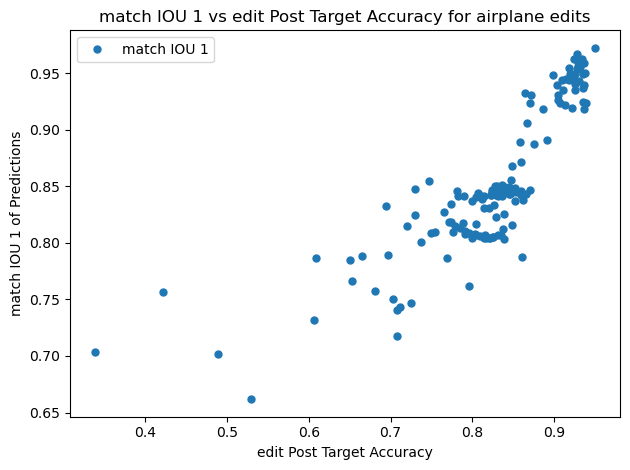

{'Target Accuracy': {'pre': 0.9470000000000001, 'edit': 0.8247721518987341, 'logit bump': 0.8242531645569618, 'mean diff': 0.0005189873417721516}, 'Mean Accuracy': {'pre': 0.6870000000000002, 'edit': 0.6110379746835443, 'logit bump': 0.6387405063291139, 'mean diff': -0.027702531645569642}, 'n_samples': 158, 'n_improvements': 1, 'match IOU 1': {'n_top': 3, 'top match IOU 1': (0.9487809523809524, 0.024441251234434816), 'bottom match IOU 1': (0.7203523809523809, 0.031018711710683242)}}
[0310_144546] Saving metrics for automobile class...


122it [01:03,  1.93it/s]

n improved: 0
Looking at 14 rows for granular metrics


<Figure size 640x480 with 0 Axes>

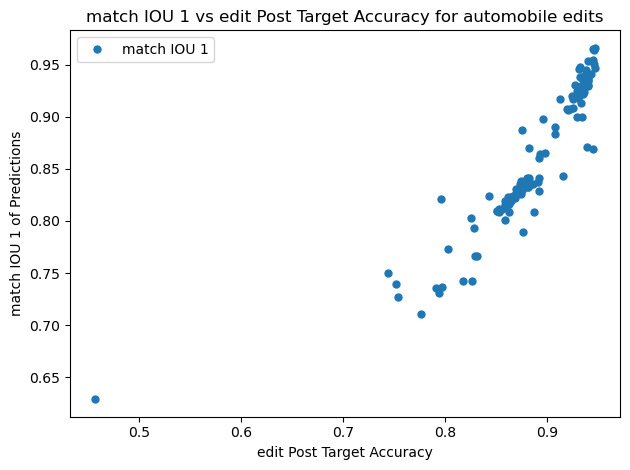

{'Target Accuracy': {'pre': 0.9499999999999998, 'edit': 0.8846147540983605, 'logit bump': 0.8822868852459017, 'mean diff': 0.0023278688524590147}, 'Mean Accuracy': {'pre': 0.6869999999999999, 'edit': 0.6389672131147541, 'logit bump': 0.6634672131147541, 'mean diff': -0.024500000000000022}, 'n_samples': 122, 'n_improvements': 0, 'match IOU 1': {'n_top': 14, 'top match IOU 1': (0.941434693877551, 0.024298385003788416), 'bottom match IOU 1': (0.7453112244897959, 0.046195057119890366)}}
[0310_144649] Saving metrics for bird class...


146it [01:15,  1.93it/s]


n improved: 0
Looking at 2 rows for granular metrics


<Figure size 640x480 with 0 Axes>

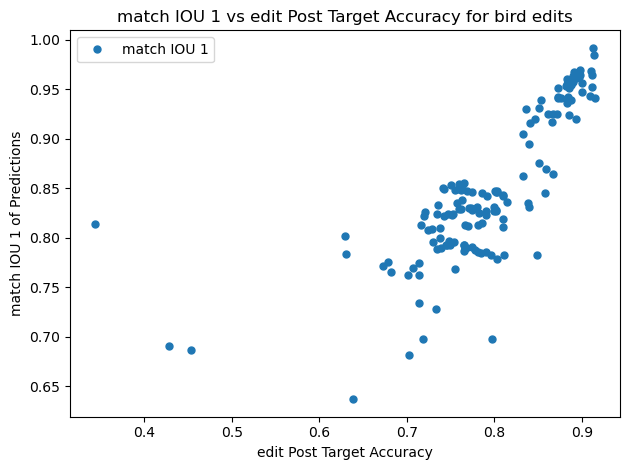

{'Target Accuracy': {'pre': 0.923, 'edit': 0.7906369863013698, 'logit bump': 0.7967191780821917, 'mean diff': -0.006082191780821918}, 'Mean Accuracy': {'pre': 0.6870000000000002, 'edit': 0.6071712328767123, 'logit bump': 0.6398082191780823, 'mean diff': -0.03263698630136989}, 'n_samples': 146, 'n_improvements': 0, 'match IOU 1': {'n_top': 2, 'top match IOU 1': (0.9626928571428572, 0.03098137854141629), 'bottom match IOU 1': (0.7517357142857143, 0.08700443866228197)}}
[0310_144805] Saving metrics for cat class...


128it [01:05,  1.95it/s]

n improved: 0
Looking at 10 rows for granular metrics


<Figure size 640x480 with 0 Axes>

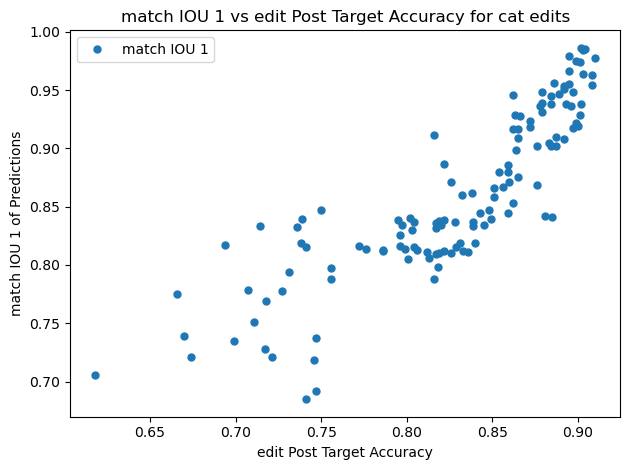

{'Target Accuracy': {'pre': 0.9109999999999997, 'edit': 0.8272421875, 'logit bump': 0.832234375, 'mean diff': -0.004992187500000003}, 'Mean Accuracy': {'pre': 0.6869999999999999, 'edit': 0.63559375, 'logit bump': 0.6657421875, 'mean diff': -0.03014843750000002}, 'n_samples': 128, 'n_improvements': 0, 'match IOU 1': {'n_top': 10, 'top match IOU 1': (0.9653514285714285, 0.020204007370623268), 'bottom match IOU 1': (0.7582485714285714, 0.04189286800903795)}}
[0310_144911] Saving metrics for deer class...


72it [00:36,  1.95it/s]

n improved: 2
Looking at 6 rows for granular metrics


<Figure size 640x480 with 0 Axes>

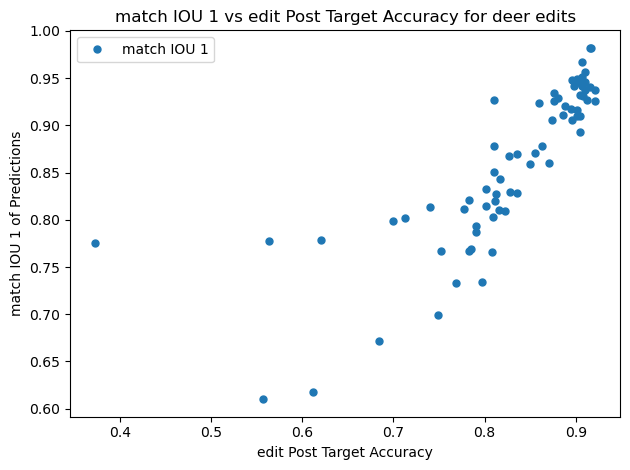

{'Target Accuracy': {'pre': 0.9200000000000002, 'edit': 0.8271111111111111, 'logit bump': 0.8332638888888888, 'mean diff': -0.006152777777777769}, 'Mean Accuracy': {'pre': 0.6870000000000002, 'edit': 0.6279444444444445, 'logit bump': 0.6562916666666667, 'mean diff': -0.028347222222222246}, 'n_samples': 72, 'n_improvements': 2, 'match IOU 1': {'n_top': 6, 'top match IOU 1': (0.9489428571428572, 0.026172571715520836), 'bottom match IOU 1': (0.7050190476190478, 0.08167751303788834)}}
[0310_144949] Saving metrics for dog class...


55it [00:28,  1.92it/s]

n improved: 1
Looking at 28 rows for granular metrics


<Figure size 640x480 with 0 Axes>

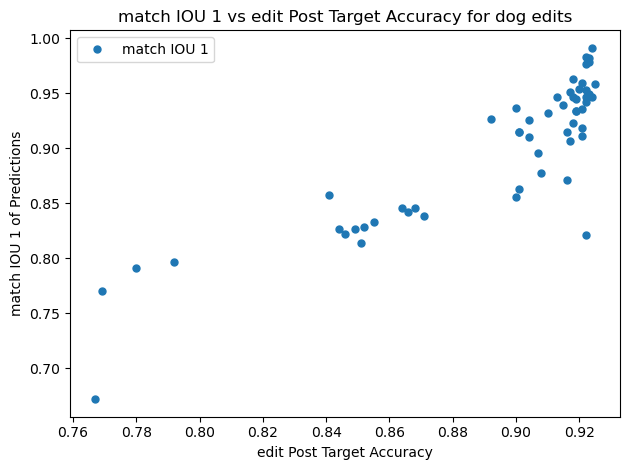

{'Target Accuracy': {'pre': 0.9249999999999996, 'edit': 0.8931999999999999, 'logit bump': 0.896872727272727, 'mean diff': -0.003672727272727274}, 'Mean Accuracy': {'pre': 0.6869999999999998, 'edit': 0.6677090909090908, 'logit bump': 0.6835818181818182, 'mean diff': -0.01587272727272724}, 'n_samples': 55, 'n_improvements': 1, 'match IOU 1': {'n_top': 28, 'top match IOU 1': (0.9404954081632653, 0.035175583775277144), 'bottom match IOU 1': (0.858748469387755, 0.06227106197970212)}}
[0310_145018] Saving metrics for frog class...


132it [01:08,  1.94it/s]

n improved: 0
Looking at 4 rows for granular metrics


<Figure size 640x480 with 0 Axes>

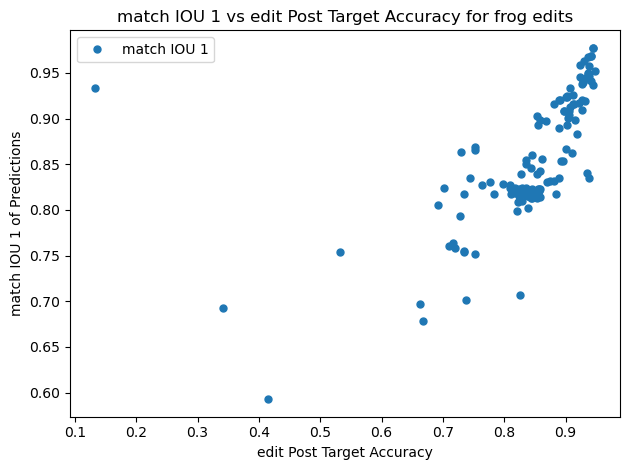

{'Target Accuracy': {'pre': 0.9530000000000002, 'edit': 0.8383787878787878, 'logit bump': 0.8411666666666667, 'mean diff': -0.0027878787878787884}, 'Mean Accuracy': {'pre': 0.687, 'edit': 0.6203484848484848, 'logit bump': 0.6470757575757576, 'mean diff': -0.026727272727272745}, 'n_samples': 132, 'n_improvements': 0, 'match IOU 1': {'n_top': 4, 'top match IOU 1': (0.9607249999999999, 0.019936454747300422), 'bottom match IOU 1': (0.7431464285714287, 0.1432269914207115)}}
[0310_145126] Saving metrics for horse class...


83it [00:42,  1.93it/s]

n improved: 4
Looking at 26 rows for granular metrics


<Figure size 640x480 with 0 Axes>

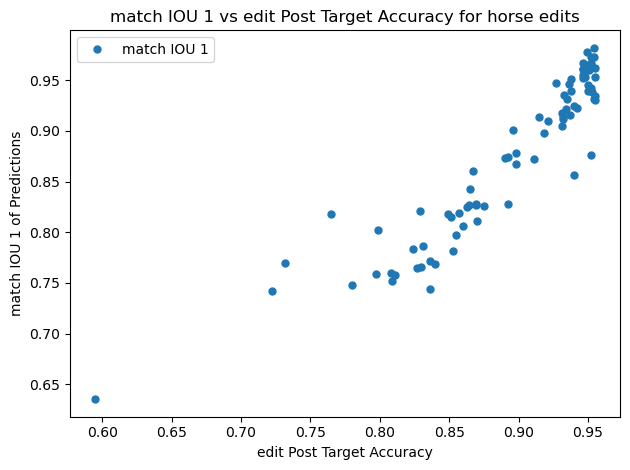

{'Target Accuracy': {'pre': 0.9549999999999998, 'edit': 0.8929156626506023, 'logit bump': 0.8976626506024097, 'mean diff': -0.004746987951807226}, 'Mean Accuracy': {'pre': 0.687, 'edit': 0.6473855421686746, 'logit bump': 0.6723493975903615, 'mean diff': -0.02496385542168673}, 'n_samples': 83, 'n_improvements': 4, 'match IOU 1': {'n_top': 26, 'top match IOU 1': (0.9531032967032969, 0.020991313775062758), 'bottom match IOU 1': (0.7783532967032968, 0.04025523275559615)}}
[0310_145210] Saving metrics for ship class...


67it [00:34,  1.92it/s]

n improved: 0
Looking at 18 rows for granular metrics


<Figure size 640x480 with 0 Axes>

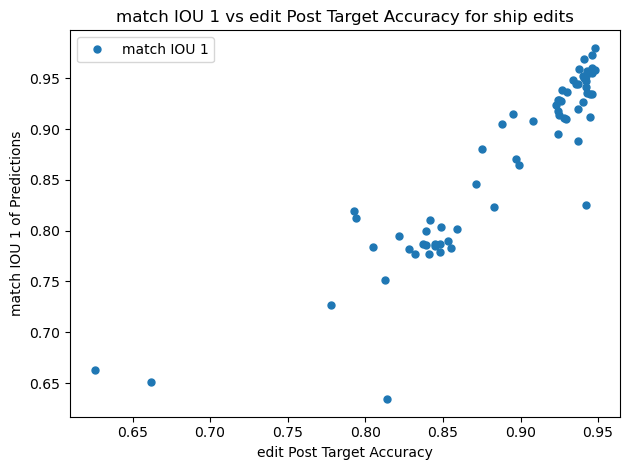

{'Target Accuracy': {'pre': 0.9489999999999998, 'edit': 0.8876567164179104, 'logit bump': 0.8912985074626867, 'mean diff': -0.0036417910447761226}, 'Mean Accuracy': {'pre': 0.687, 'edit': 0.6474328358208955, 'logit bump': 0.6733432835820896, 'mean diff': -0.025910447761194028}, 'n_samples': 67, 'n_improvements': 0, 'match IOU 1': {'n_top': 18, 'top match IOU 1': (0.9424468253968252, 0.03372331733661751), 'bottom match IOU 1': (0.7626484126984128, 0.05637911440551187)}}
[0310_145245] Saving metrics for truck class...


119it [01:01,  1.93it/s]

n improved: 0
Looking at 25 rows for granular metrics


<Figure size 640x480 with 0 Axes>

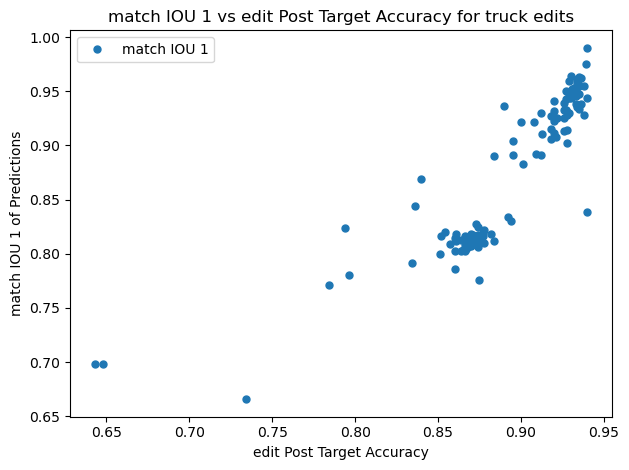

{'Target Accuracy': {'pre': 0.9410000000000004, 'edit': 0.892201680672269, 'logit bump': 0.8848655462184876, 'mean diff': 0.007336134453781515}, 'Mean Accuracy': {'pre': 0.6869999999999998, 'edit': 0.6513949579831935, 'logit bump': 0.6710672268907567, 'mean diff': -0.019672268907563042}, 'n_samples': 119, 'n_improvements': 0, 'match IOU 1': {'n_top': 25, 'top match IOU 1': (0.9478668571428572, 0.026393334849726655), 'bottom match IOU 1': (0.7950737142857142, 0.045154499078993555)}}
{'airplane': {'Target Accuracy': {'pre': 0.9470000000000001, 'edit': 0.8247721518987341, 'logit bump': 0.8242531645569618, 'mean diff': 0.0005189873417721516}, 'Mean Accuracy': {'pre': 0.6870000000000002, 'edit': 0.6110379746835443, 'logit bump': 0.6387405063291139, 'mean diff': -0.027702531645569642}, 'n_samples': 158, 'n_improvements': 1, 'match IOU 1': {'n_top': 3, 'top match IOU 1': (0.9487809523809524, 0.024441251234434816), 'bottom match IOU 1': (0.7203523809523809, 0.031018711710683242)}}, 'automobile

TypeError: expected str, bytes or os.PathLike object, not NoneType

In [31]:
# df_save_root = os.path.join('temp')
df_save_root = None
all_metrics = save_metrics(
    overall_metric_names=['Target Accuracy', 'Mean Accuracy'],
    granular_metric_names=['match IOU'],
    granular_sort_metric="Target Accuracy",
    granular_criteria=('window', 0.01), # threshold, cutoff #, cutoff %
    id1='edit',
    id2='logit bump',
    df_save_root=df_save_root) 

print(all_metrics)
if df_save_root is not None:
    torch_save_path = os.path.join(os.path.dirname(logit_bump_dir_template), 'all_class_results.pth')
    json_save_path = os.path.join(os.path.dirname(logit_bump_dir_template), 'all_class_results.json')
else:
    torch_save_path = os.path.join(df_save_root, 'all_class_results.pth')
    json_save_path = os.path.join(df_save_root, 'all_class_results.json')

torch.save(all_metrics, torch_save_path)
with open(json_save_path, 'w') as f:
    json.dump(all_metrics, f, indent=4)

### Loop through the corresponding edit bump trials to obtain the combined CSVs, combine into one and obtain reportable metrics

In [11]:
df_save_root = None
if df_save_root is None:
    trial_dir_template = 'saved/edit_eac/experiments/corresponding_bump_edits/CINIC10_ImageNet-VGG_16/0227_144100/{}_{}'
else:
    trial_dir_template = os.path.join(df_save_root, '{}')
combined_csv_path_template = os.path.join(trial_dir_template, 'combined_df_IOU_Spearman.csv')
save_dir = os.path.dirname(trial_dir_template)

# Things to load
all_class_csv_save_path = os.path.join(save_dir, 'all_class_csv.csv')
all_class_results_torch_path = os.path.join(save_dir, 'all_class_results.pth')

# Things to save



In [12]:
# Create combined CSV (probably don't have to run again)
all_class_df = None
for class_name in class_list:
    combined_csv_path = combined_csv_path_template.format(class_name, n_select)
    print("Obtaining csv for {} class from {}".format(class_name, combined_csv_path))
    
    class_df = load_and_preprocess_csv(csv_path=combined_csv_path)
    if all_class_df is None:
        all_class_df = class_df
    else:
        all_class_df = all_class_df.append(class_df, ignore_index=True)

# Save CSV
all_class_df.to_csv(all_class_csv_save_path)

print("Saved CSV for all classes to {}".format(all_class_csv_save_path))

Obtaining csv for airplane class from saved/edit_eac/experiments/corresponding_bump_edits/CINIC10_ImageNet-VGG_16/0227_144100/airplane_100/combined_df_IOU_Spearman.csv
Obtaining csv for automobile class from saved/edit_eac/experiments/corresponding_bump_edits/CINIC10_ImageNet-VGG_16/0227_144100/automobile_100/combined_df_IOU_Spearman.csv
Obtaining csv for bird class from saved/edit_eac/experiments/corresponding_bump_edits/CINIC10_ImageNet-VGG_16/0227_144100/bird_100/combined_df_IOU_Spearman.csv
Obtaining csv for cat class from saved/edit_eac/experiments/corresponding_bump_edits/CINIC10_ImageNet-VGG_16/0227_144100/cat_100/combined_df_IOU_Spearman.csv
Obtaining csv for deer class from saved/edit_eac/experiments/corresponding_bump_edits/CINIC10_ImageNet-VGG_16/0227_144100/deer_100/combined_df_IOU_Spearman.csv
Obtaining csv for dog class from saved/edit_eac/experiments/corresponding_bump_edits/CINIC10_ImageNet-VGG_16/0227_144100/dog_100/combined_df_IOU_Spearman.csv
Obtaining csv for frog c

## Load data to analyze results

In [13]:
# Obtain combined CSV, all_results torch
all_class_csv_save_path = os.path.join(save_dir, 'all_class_csv.csv')

all_class_df = load_and_preprocess_csv(csv_path=all_class_csv_save_path)
all_class_results = torch.load(all_class_results_torch_path)

# Only look at rows where data is masked
all_class_df = all_class_df[all_class_df['edit ID'].str.contains('masked')]
print("{} masked rows".format(len(all_class_df)))
overall_results = {}

563 masked rows


#### Obtain # of example that improved target class accuracy and overall accuracy

In [46]:
n_improve_target_accuracy = len(all_class_df[all_class_df['edit Pre Target Accuracy'] < all_class_df['edit Post Target Accuracy']])
print("{} improved target class accuracy".format(n_improve_target_accuracy))

n_improve_overall_accuracy = len(all_class_df[all_class_df['edit Pre Mean Accuracy'] < all_class_df['edit Post Mean Accuracy']])
print("{} improved overall accuracy".format(n_improve_overall_accuracy))

#
pre_class_dists = all_class_df['edit Pre Class Dist'].to_numpy()
post_class_dists = all_class_df['edit Post Class Dist'].to_numpy()
target_class = all_class_df['edit Post val Prediction'].to_numpy()

pre_target_preds = []
post_target_preds = []
for row_idx, target_class_idx in enumerate(target_class):
    pre_target_preds.append(pre_class_dists[row_idx][target_class_idx])
    post_target_preds.append(post_class_dists[row_idx][target_class_idx])

all_class_df['edit Num Pre Target Predictions'] = pre_target_preds
all_class_df['edit Num Post Target Predictions'] = post_target_preds


n_increased_target_class = len(all_class_df[all_class_df['edit Num Pre Target Predictions'] < all_class_df['edit Num Post Target Predictions']])
print("{} imcreased target predictions".format(n_increased_target_class))    

overall_results['n_improved_target_accuracy'] = n_improve_target_accuracy
overall_results['n_improve_overall_accuracy'] = n_improve_overall_accuracy
overall_results['n_increased_target_class'] = n_increased_target_class


2 improved target class accuracy
15 improved overall accuracy
563 imcreased target predictions


#### Obtain difference in target and overall accuracy between calibration and edited model

In [47]:
edit_calibrated_diff = all_class_df['logit bump Post Target Accuracy'] - all_class_df['edit Post Target Accuracy']
mean_edit_calibrated_diff = edit_calibrated_diff.mean()
std_edit_calibrated_diff = edit_calibrated_diff.std()

print("On average, calibrated target accuracy differs from edited target accuracy by {} ({})".format(mean_edit_calibrated_diff, std_edit_calibrated_diff)) 
overall_results['diff_target_accuracy'] = (mean_edit_calibrated_diff, std_edit_calibrated_diff)
    

On average, calibrated target accuracy differs from edited target accuracy by 0.0020994671403197175 (0.00764939346328353)


### Obtain box plot of IOU for various prediction rankings

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


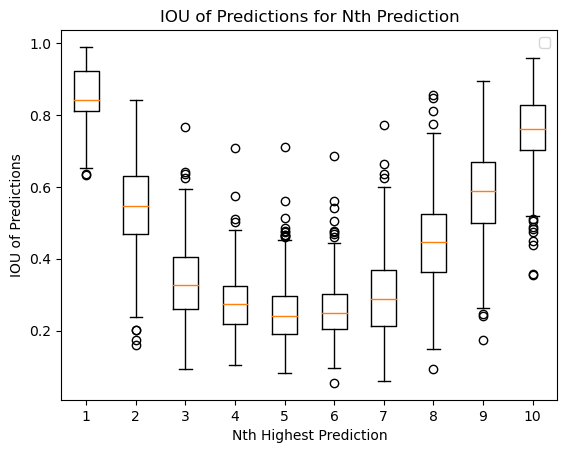

(<Figure size 640x480 with 1 Axes>,
 <AxesSubplot:title={'center':'IOU of Predictions for Nth Prediction'}, xlabel='Nth Highest Prediction', ylabel='IOU of Predictions'>)

In [14]:
boxplot_data = []
labels = []
n_classes = len(class_list)
boxplot_save_path =os.path.join(save_dir, 'ranked_IOU_boxplot.pdf')
for i in range(n_classes):
    ranked_IOU = all_class_df['match IOU {}'.format(i+1)].to_numpy()
    boxplot_data.append(ranked_IOU)
    labels.append(i+1)
    
boxplot(
    data=boxplot_data,
    labels=labels,
    xlabel_rotation=0,
    xlabel='Nth Highest Prediction',
    ylabel='IOU of Predictions',
    title='IOU of Predictions for Nth Prediction',
    save_path=boxplot_save_path)

#### Graph IOU vs Post target accuracy for all edits

<Figure size 640x480 with 0 Axes>

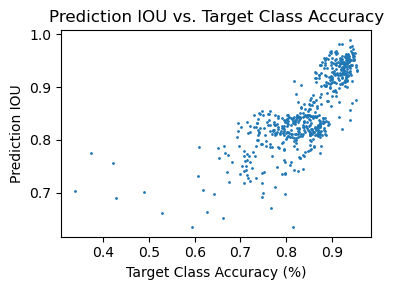

Saved IOU plot to saved/edit_eac/experiments/corresponding_bump_edits/CINIC10_ImageNet-VGG_16/0227_144100/match_IOU_vs_post_target_acc.pdf
Pearson correlation coefficient: 0.7699249770501324 pvalue: 1.5704116745371682e-111
Average Match: IOU: 0.8549907383912713 (0.07005349445627376)


In [48]:
iou_plot_save_path = os.path.join(save_dir, 'match_IOU_vs_post_target_acc.pdf')

x_col = 'edit Post Target Accuracy'
y_col = 'match IOU'
sort_post_target_acc_df = all_class_df.sort_values(x_col)
xs = sort_post_target_acc_df[x_col].to_numpy()
match_ious = sort_post_target_acc_df[y_col].to_numpy()


plot(
    xs=[xs],
    ys=[match_ious],
    marker_size=1,
    title='Prediction IOU vs. Target Class Accuracy',
    xlabel='Target Class Accuracy (%)',
    ylabel='Prediction IOU',
    line=False,
    show=True,
    fig_size=(4,3),
    save_path=iou_plot_save_path)
print("Saved IOU plot to {}".format(iou_plot_save_path))
# Calculate the Pearson correlation coefficient
linreg = stats.linregress(x=xs, y=match_ious)
print("Pearson correlation coefficient: {} pvalue: {}".format(linreg.rvalue, linreg.pvalue))
overall_results['IOU'] = {
    'pearson': linreg.rvalue,
    'pvalue': linreg.pvalue,
    'slope': linreg.slope,
    'yint': linreg.intercept
}

print("Average Match: IOU: {} ({})".format(np.mean(match_ious), np.std(match_ious)))

<Figure size 640x480 with 0 Axes>

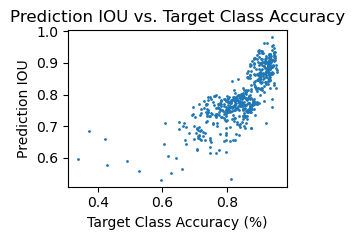

Saved IOU plot to saved/edit_eac/experiments/corresponding_bump_edits/CINIC10_ImageNet-VGG_16/0227_144100/weighted_IOU_vs_post_target_acc.pdf
Pearson correlation coefficient: 0.7779924239786312 pvalue: 2.496279874368168e-115
Average Weighted IOU: 0.7940746049296895 (0.08109174782120473)


In [49]:
iou_plot_save_path = os.path.join(save_dir, 'weighted_IOU_vs_post_target_acc.pdf')

x_col = 'edit Post Target Accuracy'
y_col = 'weighted IOU'
sort_post_target_acc_df = all_class_df.sort_values(x_col)
xs = sort_post_target_acc_df[x_col].to_numpy()
weighted_ious = sort_post_target_acc_df[y_col].to_numpy()


plot(
    xs=[xs],
    ys=[weighted_ious],
    marker_size=1,
    title='Prediction IOU vs. Target Class Accuracy',
    xlabel='Target Class Accuracy (%)',
    ylabel='Prediction IOU',
    line=False,
    show=True,
    fig_size=(3,2.5),
    save_path=iou_plot_save_path)
print("Saved IOU plot to {}".format(iou_plot_save_path))
# Calculate the Pearson correlation coefficient
linreg = stats.linregress(x=xs, y=weighted_ious)
print("Pearson correlation coefficient: {} pvalue: {}".format(linreg.rvalue, linreg.pvalue))
overall_results['IOU'] = {
    'pearson': linreg.rvalue,
    'pvalue': linreg.pvalue,
    'slope': linreg.slope,
    'yint': linreg.intercept
}

print("Average Weighted IOU: {} ({})".format(np.mean(weighted_ious), np.std(weighted_ious)))

#### Average spearman coefficient

<Figure size 640x480 with 0 Axes>

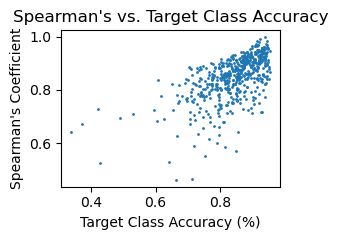

Pearson correlation coefficient: 0.6136308753139785 pvalue: 1.5182515928747201e-59
Spearman's: 0.8494228144512473 (0.0831799243506431)
Spearman's % of trials with pval < 0.001: 1.0


In [50]:
# spearmans = all_class_df['Spearman']
spearmans_plot_save_path = os.path.join(save_dir, 'spearman_vs_post_target_acc.pdf')

x_col = 'edit Post Target Accuracy'
sort_post_target_acc_df = all_class_df.sort_values(x_col)
xs = sort_post_target_acc_df[x_col].to_numpy()
spearmans = sort_post_target_acc_df['Spearman'].to_numpy()


plot(
    xs=[xs],
    ys=[spearmans],
    marker_size=1,
    title="Spearman's vs. Target Class Accuracy",
    xlabel='Target Class Accuracy (%)',
    ylabel="Spearman's Coefficient",
    line=False,
    show=True,
    fig_size=(3,2.5),
    save_path=spearmans_plot_save_path)
# print("Saved IOU plot to {}".format(iou_plot_save_path))
# Calculate the Pearson correlation coefficient
linreg = stats.linregress(x=xs, y=spearmans)
print("Pearson correlation coefficient: {} pvalue: {}".format(linreg.rvalue, linreg.pvalue))
overall_results['IOU'] = {
    'pearson': linreg.rvalue,
    'pvalue': linreg.pvalue,
    'slope': linreg.slope,
    'yint': linreg.intercept
}
mean_spearmans = spearmans.mean()
std_spearmans = spearmans.std()

print("Spearman's: {} ({})".format(mean_spearmans, std_spearmans))
print("Spearman's % of trials with pval < 0.001: {}".format(
    len(all_class_df[all_class_df['Spearman pvalue'] < 0.001]) / len(all_class_df)))
overall_results['Spearmans'] = (mean_spearmans, std_spearmans)


### Plot both IOU and Spearman's on same plot

<Figure size 640x480 with 0 Axes>

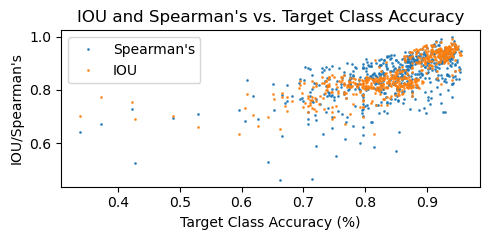

(<Figure size 500x250 with 1 Axes>,
 <AxesSubplot:title={'center':"IOU and Spearman's vs. Target Class Accuracy"}, xlabel='Target Class Accuracy (%)', ylabel="IOU/Spearman's">)

In [52]:
iou_type = 'match'
if iou_type == 'match':
    ious = match_ious
elif iou_type == 'weighted':
    ious = weighted_ious
else:
    raise ValueError("Invalid IOU type")
both_plot_save_path = os.path.join(save_dir, 'iou_spearman_vs_post_target_acc.pdf')

plot(
    xs=[xs, xs],
    ys=[spearmans, ious],
    labels=["Spearman's", "IOU"],
    alpha=0.8,
    marker_size=1,
    title="IOU and Spearman's vs. Target Class Accuracy",
    xlabel='Target Class Accuracy (%)',
    ylabel="IOU/Spearman's",
    line=False,
    show=True,
    fig_size=(5,2.5),
    save_path=both_plot_save_path)

In [ ]:
### Create Boxplots 